# DataBlock API

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from exp.nb_07a import *

## Image ItemList

Previously we were reading in to RAM the whole MNIST dataset at once, loading it as a pickle file. We can't do that for datasets larger than our RAM capacity, so instead we leave the images on disk and just grab the ones we need for each mini-batch as we use them.

Let's use the [imagenette dataset](https://github.com/fastai/imagenette/blob/master/README.md) and build the data blocks we need along the way.

### Get images

In [3]:
path = Path('/storage/data/imagenette2-160')
path.ls()

[PosixPath('/storage/data/imagenette2-160/val'),
 PosixPath('/storage/data/imagenette2-160/train')]

In [4]:
#export
import PIL,os,mimetypes
# Path.ls = lambda x: list(x.iterdir())

In [5]:
(path/'val').ls()

[PosixPath('/storage/data/imagenette2-160/val/n03028079'),
 PosixPath('/storage/data/imagenette2-160/val/n02102040'),
 PosixPath('/storage/data/imagenette2-160/val/n01440764'),
 PosixPath('/storage/data/imagenette2-160/val/n03394916'),
 PosixPath('/storage/data/imagenette2-160/val/n03417042'),
 PosixPath('/storage/data/imagenette2-160/val/n02979186'),
 PosixPath('/storage/data/imagenette2-160/val/n03445777'),
 PosixPath('/storage/data/imagenette2-160/val/n03425413'),
 PosixPath('/storage/data/imagenette2-160/val/n03888257'),
 PosixPath('/storage/data/imagenette2-160/val/n03000684')]

In [6]:
path_tench = path/'val'/'n01440764'

In [7]:
img_fn = path_tench.ls()[0]
img_fn

PosixPath('/storage/data/imagenette2-160/val/n01440764/n01440764_8012.JPEG')

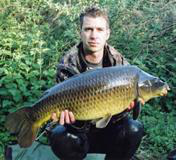

In [8]:
img = PIL.Image.open(img_fn)
img

(-0.5, 175.5, 159.5, -0.5)

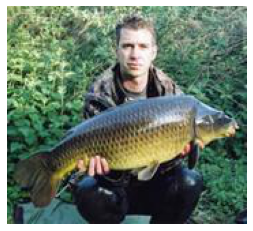

In [9]:
plt.imshow(img)
plt.axis('off')

In [10]:
import numpy as np

In [11]:
imga = np.array(img)

In [12]:
imga.shape

(160, 176, 3)

In [13]:
imga[:10, :10, 0]

array([[176, 177, 187, 176, ..., 145, 184, 187, 184],
       [136, 163, 168, 184, ..., 108, 152, 173, 167],
       [138, 158, 157, 178, ..., 111, 149, 170, 173],
       [145, 125, 131, 142, ..., 107, 125, 171, 180],
       ...,
       [147, 136,  99, 119, ..., 163, 174, 161, 121],
       [161, 152, 132, 119, ..., 149,  99,  84,  92],
       [196, 184, 174, 172, ..., 140, 109,  95, 143],
       [178, 168, 170, 159, ..., 135, 109,  85, 102]], dtype=uint8)

Just in case there are other files in the directory (models, texts...) we want to keep only the images. Let's not write it out by hand, but instead use what's already on our computer (the MIME types database).

In [14]:
#export
image_exts = set(
    k for k, v in mimetypes.types_map.items() if v.startswith('image/')
)

In [15]:
', '.join(image_exts)

'.rgb, .xpm, .tiff, .pgm, .gif, .jpg, .bmp, .png, .jpeg, .ico, .pbm, .ras, .pnm, .svg, .xwd, .tif, .ppm, .xbm, .ief, .jpe'

In [16]:
#export
def setify(o): return o if isinstance(o,set) else set(listify(o))

In [17]:
test_eq(setify('aa'), {'aa'})
test_eq(setify(['aa',1]), {'aa',1})
test_eq(setify(None), set())
test_eq(setify(1), {1})
test_eq(setify({1}), {1})

Now let's walk through the directories and grab all the images. The first private function grabs all the images inside a given directory and the second one walks (potentially recursively) through all the folder in `path`.

[Jump_to lesson 11 video](https://course.fast.ai/videos/?lesson=11&t=1325)

In [18]:
#export
def _get_files(p, fs, extensions=None):
    p = Path(p)
    res = [p/f for f in fs if not f.startswith('.')
           and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res

In [19]:
t = [o.name for o in os.scandir(path_tench)]
t = _get_files(path, t, extensions=image_exts)
t[:3]

[PosixPath('/storage/data/imagenette2-160/n01440764_8012.JPEG'),
 PosixPath('/storage/data/imagenette2-160/n01440764_2001.JPEG'),
 PosixPath('/storage/data/imagenette2-160/n01440764_10042.JPEG')]

In [20]:
#export
def get_files(path, extensions=None, recurse=False, include=None):
    path = Path(path)
    extensions = setify(extensions)
    extensions = {e.lower() for e in extensions}
    if recurse:
        res = []
        for i,(p,d,f) in enumerate(os.walk(path)): # returns (dirpath, dirnames, filenames)
            if include is not None and i==0: d[:] = [o for o in d if o in include]
            else:                            d[:] = [o for o in d if not o.startswith('.')]
            res += _get_files(p, f, extensions)
        return res
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        return _get_files(path, f, extensions)

In [21]:
get_files(path_tench, image_exts)[:3]

[PosixPath('/storage/data/imagenette2-160/val/n01440764/n01440764_8012.JPEG'),
 PosixPath('/storage/data/imagenette2-160/val/n01440764/n01440764_2001.JPEG'),
 PosixPath('/storage/data/imagenette2-160/val/n01440764/n01440764_10042.JPEG')]

In [22]:
all_fns = get_files(path, image_exts, recurse=True)
len(all_fns)

13394

## Prepare for modeling

What we need to do:

- Get files
- Split validation set
  - random%, folder name, csv, ...
- Label: 
  - folder name, file name/re, csv, ...
- Transform per image (optional)
- Transform to tensor
- DataLoader
- Transform per batch (optional)
- DataBunch
- Add test set (optional)

### Get files

We use the `ListContainer` class from notebook 06 to store our objects in an `ItemList`. The `get` method will need to be subclassed to explain how to access an element (open an image for instance), then the private `_get` method can allow us to apply any additional transform to it.

`new` will be used in conjunction with `__getitem__` (that works for one index or a list of indices) to create training and validation set from a single stream when we split the data.

In [23]:
#export
def compose(x, funcs, *args, order_key='_order', **kwargs):
    key = lambda o: getattr(o, order_key, 0)
    for f in sorted(listify(funcs), key=key): x = f(x, **kwargs)
    return x

class ItemList(ListContainer):
    def __init__(self, items, path='.', tfms=None):
        super().__init__(items)
        self.path,self.tfms = Path(path),tfms

    def __repr__(self):
        return f'{super().__repr__()}\nPath: {self.path}'
    
    def new(self, items, cls=None):
        if cls is None:
            cls=self.__class__
        return cls(items, self.path, tfms=self.tfms)
    
    def  get(self, i):
        return i
    def _get(self, i):
        return compose(self.get(i), self.tfms)
    
    def __getitem__(self, idx):
        res = super().__getitem__(idx)
        if isinstance(res,list):
            return [self._get(o) for o in res]
        return self._get(res)

class ImageList(ItemList):
    @classmethod
    def from_files(cls, path, extensions=None, recurse=True, include=None, **kwargs):
        if extensions is None: extensions = image_exts
        return cls(get_files(path, extensions, recurse=recurse, include=include), path, **kwargs)
    
    def get(self, fn): return PIL.Image.open(fn)

Transforms aren't only used for data augmentation. To allow total flexibility, `ImageList` returns the raw PIL image. The first thing is to convert it to 'RGB' (or something else).

Transforms only need to be functions that take an element of the `ItemList` and transform it. If they need state, they can be defined as a class. Also, having them as a class allows to define an `_order` attribute (default 0) that is used to sort the transforms.

In [24]:
#export
class Transform(): _order=0

class MakeRGB(Transform):
    def __call__(self, item): return item.convert('RGB')

def make_rgb(item): return item.convert('RGB')

In [25]:
il = ImageList.from_files(path, tfms=make_rgb)

In [26]:
il

ImageList (13394 items)
[PosixPath('/storage/data/imagenette2-160/val/n03028079/n03028079_11250.JPEG'), PosixPath('/storage/data/imagenette2-160/val/n03028079/n03028079_29362.JPEG'), PosixPath('/storage/data/imagenette2-160/val/n03028079/n03028079_4902.JPEG'), PosixPath('/storage/data/imagenette2-160/val/n03028079/n03028079_52470.JPEG'), PosixPath('/storage/data/imagenette2-160/val/n03028079/n03028079_13002.JPEG'), PosixPath('/storage/data/imagenette2-160/val/n03028079/n03028079_2951.JPEG'), PosixPath('/storage/data/imagenette2-160/val/n03028079/n03028079_7021.JPEG'), PosixPath('/storage/data/imagenette2-160/val/n03028079/n03028079_13311.JPEG'), PosixPath('/storage/data/imagenette2-160/val/n03028079/n03028079_6491.JPEG'), PosixPath('/storage/data/imagenette2-160/val/n03028079/n03028079_35160.JPEG')...]
Path: /storage/data/imagenette2-160

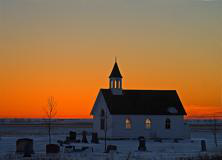

In [27]:
img = il[0]
img